In [1]:
import numpy as np
import scipy.io as io
from random import randint
from scipy.io import loadmat
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [30]:
def load_data(filename):
    data = loadmat(filename)
    X = data['data']
    Y = data['info'][0]
    X_train = np.zeros((len(X),X[0,0].shape[1]))
    for i in range(len(X)):
        X_train[i,:]=X[i,0] 
        
    # build word-id dictionary
    with open('dictionary.txt') as f:
        words = [l.strip() for l in f if l.strip()]
    Y_train = np.zeros((360,2))
    
    word=[]
    # preprocess Y train
    for i in range(360):
        Y_train[i,0] = words.index(Y[i]['word'][0])+1 # get the word id from the dictionary
        Y_train[i,1] = randint(1, 60)
        word.append(Y[i]['word'][0])
    
    return X_train,Y_train,data,word

In [72]:
Yp = 218
n = 3240
ntrain = 2700
ntest = 540
dimx = 51
dimy = 61
dimz = 23

In [56]:
def project(filename):  
    X,wid,data,words = load_data(filename)  
    project = np.zeros((360,dimx,dimy))
    print('project data...') 
    for i in range(360):
        print(i)
        visual = visualize(i)
        for z in range(3,10):
            project[i,:,:]+=visual[:,:,z]
    print(project.shape)
    X_proj = np.reshape(project,(360,3111))
    return X_proj,wid

In [54]:
def visualize(trial):
    visual = np.zeros((dimx,dimy,dimz))
    for i in range(X.shape[1]):
        [x,y,z] = data['meta'][0]['colToCoord'][0][i]
        visual[x,y,z]=abs(X[trial,i])*255
    return visual

visualize part of the activation data

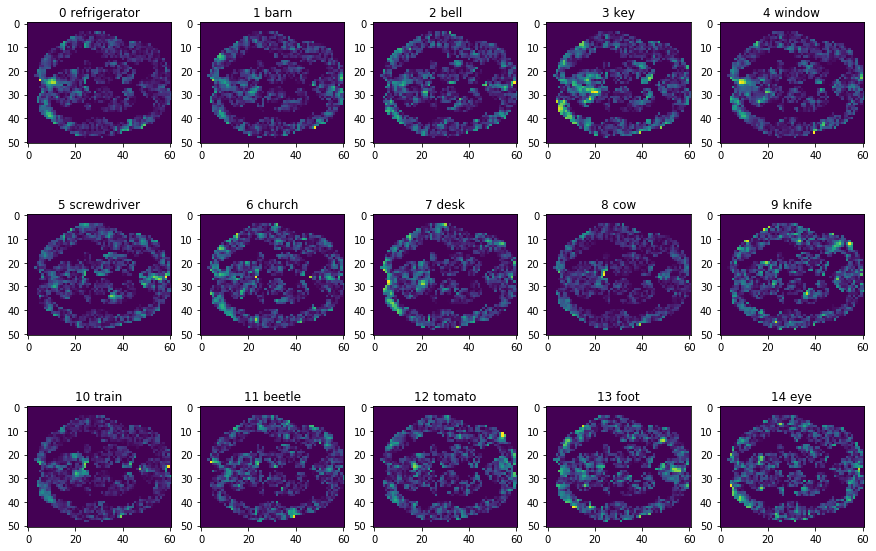

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,axs = plt.subplots(3,5,figsize=(15,10))
for i in range (15):
    visual=visualize(i)
    for j in range(3,10):
        axs[int(i/5),i%5].imshow(visual[:,:,j])
        axs[int(i/5),i%5].set_title('%i % s' % (i,words[i]))
            
plt.show()

In [73]:
X_project = np.zeros((9,360,3111))
wid_project = np.zeros((9,360,2))
for i in range(9):
    print(i)
    filename = 'data-science-P'+str(i+1)+'.mat'
    X_project[i,:,:],wid_project[i,:,:]=project(filename)


X_project = np.reshape(X_project,(n,3111))
from sklearn.decomposition import PCA
pca = PCA(n_components=300)
X = pca.fit_transform(X_project)

X = preprocessing.scale(X)

wid = np.reshape(wid_project,(n,2))
word_feature=io.mmread('word_feature_centered.mtx')

# separate data set
X_train,X_test,wid_train,wid_test = train_test_split(X,wid,test_size=1/6,random_state=42)

# # from word id to Y_train (300,1) and Y_test (60,2)
Y_train = np.zeros((ntrain,Yp))
Y_test = np.zeros((ntest,Yp))
Y2_test = np.zeros((ntest,Yp))
for i in range(ntrain):
    for j in range(Yp):
        Y_train[i][j]=word_feature[int(wid_train[i,0])-1][j]
for i in range(ntest):
    for j in range(Yp):
        Y_test[i][j]=word_feature[int(wid_test[i,0])-1][j]
        Y2_test[i][j]=word_feature[int(wid_test[i,1])-1][j]

print('shape of X train:',X_train.shape)
print('shape of X test:',X_test.shape)
print('shape of Y train:',Y_train.shape)
print('shape of Y test:',Y_test.shape)

shape of X train: (2700, 300)
shape of X test: (540, 300)
shape of Y train: (2700, 218)
shape of Y test: (540, 218)


In [74]:
class LassoShooting:
    def __init__(self, X, Y, lamda):
        self.X = X
        self.Y = Y
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.lamda = lamda
        self.w = np.zeros(self.p)
 
    def shoot(self):
        stop=False
        X = self.X
        w = self.w
        t=0
        epsilon=1e-4
        max_iter=10
        while not stop and t<max_iter:
            w_pre = w.copy()
            for j in range(self.p):
                #j = randint(0,self.p-1)
                w_nonj = np.delete(w,j)
                X_nonj = np.delete(X,j,1)  # delete k_th column
                w_j = w[j]*np.ones((self.n,1))
                r_j = X_nonj.dot(w_nonj)-self.Y
                c_j = np.sum(np.multiply(X[:,j],r_j))
                a_j = np.sum(X[:,j]**2)
                if c_j > self.lamda:
                    w[j] = (-c_j+self.lamda)/a_j
                elif c_j < (-self.lamda):
                    w[j] = (-c_j-self.lamda)/a_j
                else:
                    w[j] = 0  
            if max(abs(w-w_pre))<=epsilon:
                stop=True
            t+=1    
        self.w =w         
    
    def predict(self,X,w):
        return X.dot(w)

In [75]:
def L1(pred,y_true,y_wrong):
    score = 0
    for i in range(len(pred)):
        d1 = np.sum(np.abs(pred[i]-y_true[i]))
        d2 = np.sum(np.abs(pred[i]-y_wrong[i]))
        if d1<d2:
            score+=1
        elif d1==d2:
            score+=0.5
    return score
    
def L2(pred,y_true,y_wrong):
    score = 0
    for i in range(len(pred)):
        d1 = np.sum((pred[i]-y_true[i])**2)
        d2 = np.sum((pred[i]-y_wrong[i])**2)
        if d1<d2:
            score+=1
        elif d1==d2:
            score+=0.5
    return score

train the model

In [76]:
weight = np.zeros((X_train.shape[1],Y_train.shape[1]))
for j in range(Yp):
    print(j)
    ls = LassoShooting(X_train,Y_train[:,j],0.4)
    ls.shoot()
    weight[:,j]=ls.w
y_hat = ls.predict(X_test,weight)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217


print test results

In [77]:
print('---------All the Person--------')
print('Accuracy for L1:',L1(y_hat,Y_test,Y2_test)/len(Y_test))
print('Accuracy for L2:',L2(y_hat,Y_test,Y2_test)/len(Y_test))

---------All the Person--------
Accuracy for L1: 0.9962962962962963
Accuracy for L2: 0.9962962962962963
